<a href="https://colab.research.google.com/github/Skixio789/masef/blob/main/Delta_Hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Delta in practice is the slope of the option's price, it's the price sensitivity of an option w.r.t. spot. In the case of European Options, we have thanks to the Black-Merton-Scholes formula an explicit formula for its value which is \begin{equation*} C_t(S_t,T,K)=S_t\mathcal{N}(d_1)-e^{-r(T-t)}K\mathcal{N}(d_2)\end{equation*} for the case of the European call. Therefore its Delta is \begin{equation*} \frac{\partial C_t}{\partial S_t}(S_t,T,K)=\mathcal{N}(d_1)\end{equation*}
where \begin{align*}d_1 &= \frac{\ln\bigr(\frac{S_t}{K}\bigr)+(r+\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}},\\ d_2 &=  \frac{\ln\bigr(\frac{S_t}{K}\bigr)+(r-\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}.\end{align*}
We recall that under $\mathbb{Q}$, $(S_t)_{t\in[0,T]}$ satisfies the stochastic differential equation
\begin{equation*}
    \left\{\begin{split}
        dS_t &=r S_t dt + \sigma S_t dB_t^*\\
        S_0&=s_0.
    \end{split}\right.
\end{equation*}
Graphically we have with numerical experiments constants
\begin{equation*}K=10,\;\sigma =30\%,\; r=5\%,\; T=1\end{equation*}

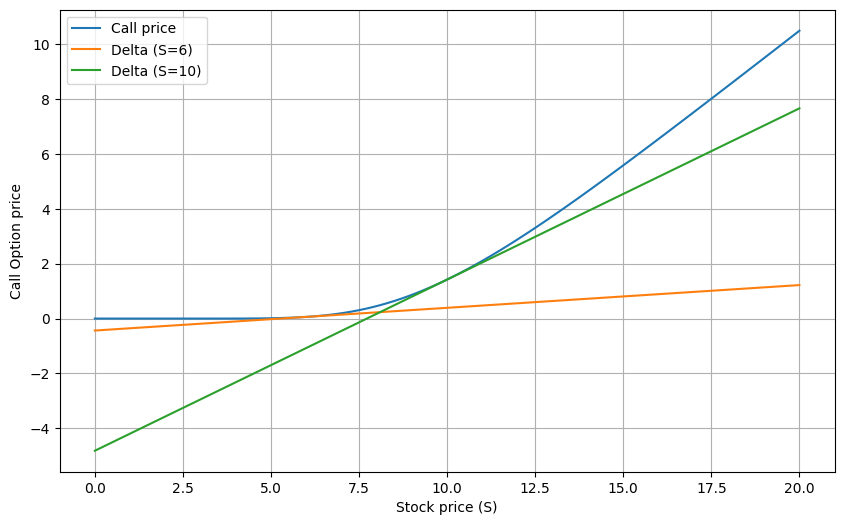

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as sps


K,r,sigma,T = 10,0.05,0.3,1 #parameter of the Black-Merton-Scholes model

def call(s,t):#function which returns the price of the European call
  if s==0:
    return 0
  if t<T:
    d1 = (np.log(s/K)+(r+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d2 = (np.log(s/K)+(r-sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    return s*sps.norm.cdf(d1)-np.exp(-r*(T-t))*K*sps.norm.cdf(d2)
  else:
    return np.maximum(s-K,0)

def delta(s,t):#function which returns the delta of the European call
  if t<T:
    d1=(np.log(s/K)+(r+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    return sps.norm.cdf(d1)
  else:
    return int((s-K>0))+1/2*int((s==K))

s=np.linspace(0,20,100)
call_values = np.array([call(s,0) for s in s])

fig,ax = plt.subplots(figsize = (10,6))
ax.plot(s,call_values,label="Call price")
ax.plot(s,delta(6,0)*s+call(6,0)-delta(6,0)*6,label="Delta (S=6)")
ax.plot(s,delta(10,0)*s+call(10,0)-delta(10,0)*10,label="Delta (S=10)")
ax.legend()
plt.xlabel("Stock price (S)")
plt.ylabel("Call Option price")
plt.grid()
plt.show()






We are considering the parameter $K=100,\;\sigma =20\%,\; r=5\%,\; T=20/52,\; S_0=95$ for the Black-Merton-Scholes model. We are currently delta hedging $100,000$ European Call Options with these parameters and under our assumptions, the price of the underlying is in our case a geometric Brownian Motion under $\mathbb{Q}$ (also under $\mathbb{P}$ but we're working under $\mathbb{Q}$), so we have for all $t\in[0,T]$
\begin{equation*}
  S_t = s_0 e^{(r-\frac{\sigma^2}{2})t+\sigma B_t}
\end{equation*}
where $(B_t)_{t\geq 0}$ is a standard Brownian motion under $\mathbb{Q}$. We decide arbitrarily to delta hedge every week until the maturity which is $20$ weeks.

In [ ]:
from numpy.random import default_rng
import pandas as pd

rng = default_rng()

r,sigma,x,K,T=0.05,0.20,95,100,20/52 #parameter of the Black-Merton-Scholes model
delta_hedge_time=21 #We decide to hedge every week for instance, it could be more or less
number_of_contract = 100000 #Number of contracts hedged

b = np.zeros(delta_hedge_time)
b[1::]=np.sqrt(T/delta_hedge_time)*rng.normal(size = delta_hedge_time-1)
brownian = np.cumsum(b) #Modelisation of a standard Brownian motion between 0 and T

t=np.linspace(0,T,delta_hedge_time)
s = x*np.exp((r-sigma**2/2)*t+sigma*brownian) #Modelisation of a possible trajectory of the underlying


delta_values = np.array([delta(s[i],t[i]) for i in range(delta_hedge_time)]) #All delta needed to delta hedge

orders = number_of_contract*(delta_values[1::]-delta_values[0:-1])
orders = np.insert(orders,0,number_of_contract*delta_values[0]) #Orders to buy or sell the stock

cumulative_costs = np.cumsum(orders*s) #Cumulative costs of the strategy (not including interest costs)


interest_costs = cumulative_costs*(np.exp(r/52)-1) #All interest costs from the strategy
interest_costs[-1]=0 #At maturity we don't have to hold longer the shares purchased
cumulative_costs_with_interest = cumulative_costs.copy()
cumulative_costs_with_interest[1::]=cumulative_costs_with_interest[1::]+np.cumsum(interest_costs[0:-1]) #Cumulative costs of the strategy including interest costs

df = pd.DataFrame(
    {
        "Week":np.arange(21),
        "Stock price":np.round(s,2),
        "Delta":np.round(delta_values,4),
        "Shares purchased":np.round(orders,2),
        "Shares held":np.round(np.cumsum(orders),2),
        "Cost of shares purchased":np.round(orders*s,2),
        "Cumulative costs including interest cost":np.round(cumulative_costs_with_interest,2),
        "Interest costs":np.round(interest_costs,2)
    }
)

print(df)
df.to_csv('/content/sample_data/mydata.csv', index=False)

Euler Scheme: We want to compare graphically the classical trajectory from the explicit formula gave by the Black-Merton-Scholes formula of the underlying and from the Euler scheme $(\bar{S}_t)_{t\geq 0}$ where
\begin{align}
    \bar{S}_{t_{i+1}}^n&=\bar{S}_{t_{i}}^n+b(\bar{S}_{t_{i}}^n)\Delta t + \theta(\bar{S}_{t_{i}}^n)\Delta B_i\\
    \nonumber
    \bar{S}_{0}^n&= s_0,
\end{align}
and
\begin{equation}
  S_t = s_0e^{(r-\frac{\sigma^2}{2})t+\sigma B_t}.
\end{equation}
We'll consider the following parameters for the Black-Merton-Scholes model
\begin{equation}
  s_0=100,\; r = 5\%,\;\sigma = 20\%,\;T =1
\end{equation}
and $n_1=10,\;n_2=1000$.


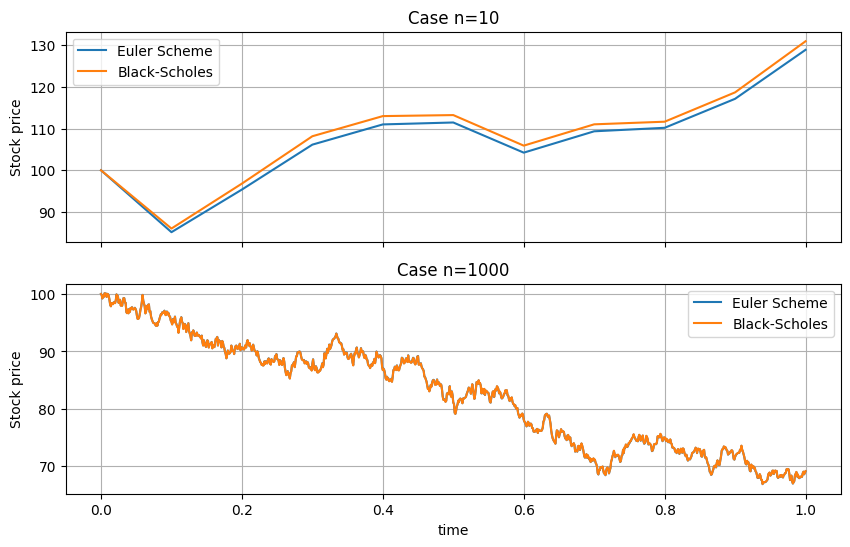

In [267]:
s,m1,m2,r,sigma,T=100,10,1000,0.05,0.2,1

b_1 = np.zeros(m1+1)
b_1[1::]=np.sqrt(T/m1)*rng.normal(size = m1)
brownian_1=np.cumsum(b_1)
S_euler_1 = 1+r*T/m1+sigma*b_1
S_euler_1[0]=s
S_euler_1 = np.cumprod(S_euler_1)
t_1= np.linspace(0,T,m1+1)
S_black_scholes_1 = s*np.exp((r-sigma**2/2)*t_1+sigma*brownian_1)

b_2 = np.zeros(m2+1)
b_2[1::]=np.sqrt(T/m2)*rng.normal(size = m2)
brownian_2=np.cumsum(b_2)
S_euler_2 = 1+r*T/m2+sigma*b_2
S_euler_2[0]=s
S_euler_2 = np.cumprod(S_euler_2)
t_2= np.linspace(0,T,m2+1)
S_black_scholes_2 = s*np.exp((r-sigma**2/2)*t_2+sigma*brownian_2)



m=np.array([m1,m2])


t = [t_1,t_2]
S_euler = [S_euler_1,S_euler_2]
S_bs = [S_black_scholes_1,S_black_scholes_2]

fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)
for i,ax in enumerate(axs.flat):
  ax.plot(t[i],S_euler[i],label="Euler Scheme")
  ax.plot(t[i],S_bs[i],label="Black-Scholes")
  ax.grid()
  ax.legend()
  ax.set_ylabel("Stock price")
  ax.set_title(f"Case n={m[i]}")
axs[1].set_xlabel("time")
plt.show()


Since we showed on a simple example that the two trajectories were closer as $n$ increase, we want to numerically show that the error in the $L^2$ sense between two points of the trajectory tends towards 0 as $n$ increase, so we want to compute
\begin{equation}
\mathbb{E}\bigg[\Big(\bar{S}_T^n-S_T\Big)^2\bigg].
\end{equation}
Because there is no way to compute this expectation, we'll approximate it with Monte Carlo Methods, and we have for $m>>0$
\begin{equation*}
    \mathbb{E}\bigg[\Big(\bar{S}_T^n-S_T\Big)^2\bigg]\approx \frac{1}{m}\sum_{i=1}^m\bigg(\bar{S}_T^{n,i}-S_T^i\bigg)^2.
\end{equation*}
For numerical experiment, we consider $m=10^4$, and the same parameters for the Black-Merton-Scholes model as before.

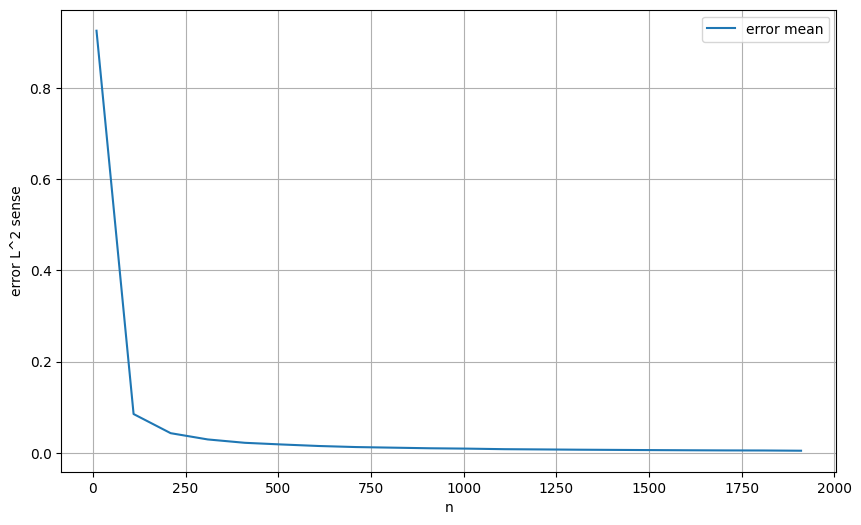

In [292]:
m=10**4
error = np.array([])
time = np.array([])
for n in range(10,2000,100):
  b = np.zeros([m,n+1])
  b[:,1::] = np.sqrt(T/n)*rng.normal(size = [m,n])
  brownian = np.cumsum(b,axis = 1)
  S_euler = 1+r*T/n+sigma*b
  S_euler[:,0]=s
  S_euler = np.cumprod(S_euler,axis =1)
  S_bs = s*np.exp((r-sigma**2/2)*T+sigma*brownian[:,-1])
  error=np.append(error,((S_euler[:,-1]-S_bs)**2).mean())
  time=np.append(time,n)
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(time,error,label = "error mean")
plt.grid()
ax.set_xlabel('n')
ax.set_ylabel('error L^2 sense')
ax.legend()
plt.show()
